In [ ]:
! pip install pymorphy2
! pip install pymorphy2-dicts
! pip install DAWG-Python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8eb07db33cd03242c9d8e4eb6c2cccf9e3439437df3777978db91e9207be01f2
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 16.3 MB/s eta 0:00:00


In [ ]:
! pip install razdel

In [ ]:
! pip install navec

In [ ]:
! wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2023-11-17 06:58:53--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  18.0MB/s    in 2.8s    

2023-11-17 06:58:57 (18.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 5.7 MB/s eta 0:00:00


In [ ]:
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import re
from razdel import tokenize
from navec import Navec
import nltk
from nltk.corpus import stopwords
import pymorphy2
from sklearn.model_selection import train_test_split
import torchtext
from torchtext import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name(), torch.cuda.get_device_properties(torch.cuda.current_device)

('Tesla T4',
 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40))

In [ ]:
data = pd.read_csv('Petitions.csv')

In [ ]:
data

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство
...,...,...,...
59884,3128111,прошу закрасить граффити,Благоустройство
59885,3276713,Прошу вас отремонтировать пешеходную дорожку,Благоустройство
59886,3274663,Необходимо демонтировать незаконную рекламную ...,Незаконная информационная и (или) рекламная ко...
59887,3359308,Очень гремит на ветру металлическая часть окна...,Кровля


In [ ]:
text = np.array(data['public_petition_text'][:10000])

In [ ]:
 text

array(['снег на дороге', 'очистить кабельный киоск от рекламы',
       'Просим убрать все деревья и кустарники, которые вышли за пределы газона на пешеходную зону, начиная от подъезда №13 до подъезда №15 (фасад дома со стороны ул. Наличной).',
       ...,
       'Товарный переулок. Мусор. В администрацию Центрального района.',
       'В проезжей части просел канализационный люк.\nТребуется произвести работы по регулировке уровня колодца, устранить просадку, качественно отремонтировать асфальтовое покрытие, соблюдая технологии (рекомендуется промазывать швы битумом для дольшей сохранности покрытий).\n\nФотофиксация от 31.03.прилагается.',
       'Надписи на будке.'], dtype=object)

In [ ]:
nltk.download("stopwords")
stopwords_ru = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
text_tokenize = []

In [ ]:
text_wosw = []

In [ ]:
text_vect = []

In [ ]:
for i in range(len(text)):
  text[i] = re.sub('\d+', '', text[i])
  text[i] = re.sub('[^\s^\w]+', ' ', text[i])
  text[i] = re.sub('[a-zA-Z]+', '', text[i])
  text[i] = re.sub('\s+', ' ', text[i])
  text_tokenize.append(list(tokenize(text[i])))
  text_wosw.append([token for token in text_tokenize[i] if token.text.lower() not in stopwords_ru])
  text_vect.append(np.array([navec[morph.parse(token.text.lower())[0].normal_form]
                    if morph.parse(token.text.lower())[0].normal_form in navec
                    else navec['<unk>'] for token in text_wosw[i]]))

In [ ]:
maxLength = len(max(text_vect, key=len))

In [ ]:
maxLength

196

In [ ]:
for i in range(len(text_vect)):
  if len(text_vect[i]) < maxLength:
    pads = np.array([navec['pad'] for i in range(maxLength - len(text_vect[i]))])
    text_vect[i] = np.concatenate((text_vect[i], pads), axis=0)

In [ ]:
y = data['reason_category'][:10000]

In [ ]:
y.isna().sum()

0

In [ ]:
y.unique()

array(['Благоустройство', 'Содержание МКД',
       'Незаконная информационная и (или) рекламная конструкция', 'Фасад',
       'Водоснабжение', 'Нарушение правил пользования общим имуществом',
       'Повреждения или неисправность элементов уличной инфраструктуры',
       'Кровля', 'Состояние рекламных или информационных конструкций',
       'Нарушение порядка пользования общим имуществом', 'Подвалы',
       'Водоотведение', 'Санитарное состояние', 'Центральное отопление',
       'Незаконная реализация товаров с торгового оборудования (прилавок, ящик, с земли)'],
      dtype=object)

In [ ]:
y = y.astype('category').cat.codes

In [ ]:
y

0        0
1        0
2        0
3       11
4        0
        ..
9995     0
9996     5
9997     0
9998     8
9999     0
Length: 10000, dtype: int8

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_vect, y, test_size=0.15)

In [ ]:
X_train = torch.tensor(X_train).to(device)
X_test = torch.tensor(X_test).to(device)

<ipython-input-32-ee445d58bea1>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_train = torch.tensor(X_train).to(device)


In [ ]:
X_train = X_train.view([8500, 58800])

In [ ]:
X_test = X_test.view([1500, 58800])

In [ ]:
y_train = torch.tensor(np.array(y_train)).to(device)
y_test = torch.tensor(np.array(y_test)).to(device)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):

        super().__init__()

        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):

        output, hidden = self.rnn(x)
        output = output.squeeze(0)
        output = self.fc(output)
        output = self.softmax(output)

        return output

In [ ]:
X_train.shape

torch.Size([8500, 58800])

In [ ]:
y_train.shape

torch.Size([8500])

In [ ]:
model = RNN(X_train.shape[1], 1, 15)

In [ ]:
model = model.to(device)

In [ ]:
loss = nn.NLLLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_ds = TensorDataset(torch.tensor(X_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

<ipython-input-43-e2034b78a8e2>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ds = TensorDataset(torch.tensor(X_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))


In [ ]:
losses = []

for ep in range (100):

  for x_b, y_b in train_dl:

    y_b = y_b.type(torch.LongTensor)
    x_b, y_b = x_b.to(device), y_b.to(device)

    outputs = model(x_b)
    loss_value = loss(outputs, y_b)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss_value.item())

  print(f'Эпоха {ep + 1}, Значение функции потерь: {loss_value.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Эпоха 1, Значение функции потерь: 2.521437168121338
Эпоха 2, Значение функции потерь: 2.605186700820923
Эпоха 3, Значение функции потерь: 2.3150217533111572
Эпоха 4, Значение функции потерь: 2.4288628101348877
Эпоха 5, Значение функции потерь: 2.4020800590515137
Эпоха 6, Значение функции потерь: 2.3130850791931152
Эпоха 7, Значение функции потерь: 2.0118041038513184
Эпоха 8, Значение функции потерь: 1.9765441417694092
Эпоха 9, Значение функции потерь: 2.0692801475524902
Эпоха 10, Значение функции потерь: 2.2302019596099854
Эпоха 11, Значение функции потерь: 1.7760462760925293
Эпоха 12, Значение функции потерь: 1.7314168214797974
Эпоха 13, Значение функции потерь: 1.9667993783950806
Эпоха 14, Значение функции потерь: 1.7138035297393799
Эпоха 15, Значение функции потерь: 1.902561068534851
Эпоха 16, Значение функции потерь: 1.771881341934204
Эпоха 17, Значение функции потерь: 1.3923022747039795
Эпоха 18, Значение функции потерь: 1.6942285299301147
Эпоха 19, Значение функции потерь: 1.5541

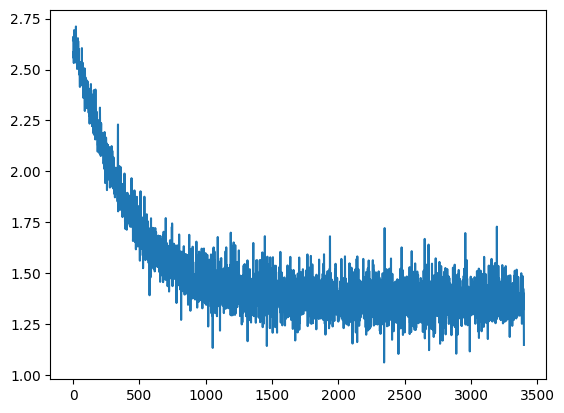

In [ ]:
plt.plot(losses)

In [ ]:
y_pred = model(X_test.type(torch.float32))

In [ ]:
y_pred

tensor([[-0.5346, -5.2295, -4.2798,  ..., -4.5167, -3.6775, -5.2375],
        [-0.5346, -5.2295, -4.2798,  ..., -4.5167, -3.6775, -5.2375],
        [-0.5346, -5.2295, -4.2798,  ..., -4.5167, -3.6775, -5.2375],
        ...,
        [-0.5346, -5.2295, -4.2798,  ..., -4.5167, -3.6775, -5.2375],
        [-0.5346, -5.2295, -4.2798,  ..., -4.5167, -3.6775, -5.2375],
        [-0.5346, -5.2295, -4.2798,  ..., -4.5167, -3.6775, -5.2375]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [ ]:
multiclass_f1_score(y_pred, y_test, num_classes=15)

tensor(0.5700, device='cuda:0')

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):

        super().__init__()

        self.gru = nn.GRU(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):

        output, hidden = self.gru(x)
        output = output.squeeze(0)
        output = self.fc(output)
        output = self.softmax(output)

        return output

In [ ]:
model1 = GRU(X_train.shape[1], 1, 15)

In [ ]:
model1 = model1.to(device)

In [ ]:
loss = nn.NLLLoss()

In [ ]:
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

In [ ]:
losses = []

for ep in range (200):

  for x_b, y_b in train_dl:

    y_b = y_b.type(torch.LongTensor)
    x_b, y_b = x_b.to(device), y_b.to(device)

    outputs = model1(x_b)
    loss_value = loss(outputs, y_b)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss_value.item())

  print(f'Эпоха {ep + 1}, Значение функции потерь: {loss_value.item()}')

Эпоха 1, Значение функции потерь: 2.894867420196533
Эпоха 2, Значение функции потерь: 2.7677879333496094
Эпоха 3, Значение функции потерь: 2.74019455909729
Эпоха 4, Значение функции потерь: 2.7117254734039307
Эпоха 5, Значение функции потерь: 2.6396431922912598
Эпоха 6, Значение функции потерь: 2.4418692588806152
Эпоха 7, Значение функции потерь: 2.4581806659698486
Эпоха 8, Значение функции потерь: 2.304051399230957
Эпоха 9, Значение функции потерь: 2.403508424758911
Эпоха 10, Значение функции потерь: 2.3003756999969482
Эпоха 11, Значение функции потерь: 2.202219009399414
Эпоха 12, Значение функции потерь: 2.112642765045166
Эпоха 13, Значение функции потерь: 2.103454113006592
Эпоха 14, Значение функции потерь: 2.0390868186950684
Эпоха 15, Значение функции потерь: 1.9181348085403442
Эпоха 16, Значение функции потерь: 1.8953588008880615
Эпоха 17, Значение функции потерь: 1.750380277633667
Эпоха 18, Значение функции потерь: 1.7839242219924927
Эпоха 19, Значение функции потерь: 1.799700856

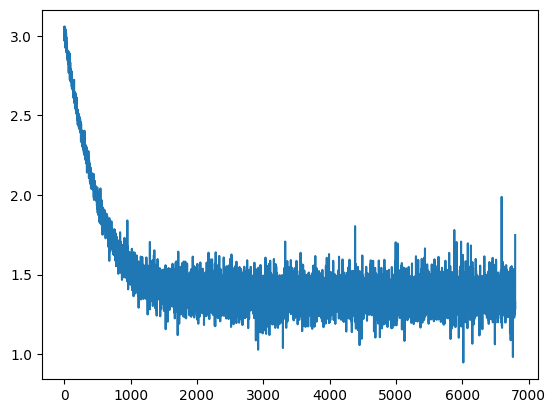

In [ ]:
plt.plot(losses)

In [ ]:
y_pred = model1(X_test.type(torch.float32))

In [ ]:
multiclass_f1_score(y_pred, y_test, num_classes=15)

tensor(0.5700, device='cuda:0')

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):

        super().__init__()

        self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):

        output, hidden = self.lstm1(x)
        output, hidden = self.lstm2(output)
        output = output.squeeze(0)
        output = self.fc(output)
        output = self.softmax(output)

        return output

In [ ]:
model2 = LSTM(X_train.shape[1], 1, 15)

In [ ]:
model2 = model2.to(device)

In [ ]:
loss = nn.NLLLoss()

In [ ]:
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [ ]:
losses = []

for ep in range (200):

  for x_b, y_b in train_dl:

    y_b = y_b.type(torch.LongTensor)
    x_b, y_b = x_b.to(device), y_b.to(device)

    outputs = model2(x_b)
    loss_value = loss(outputs, y_b)
    loss_value.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(loss_value.item())

  print(f'Эпоха {ep + 1}, Значение функции потерь: {loss_value.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Эпоха 1, Значение функции потерь: 3.0923209190368652
Эпоха 2, Значение функции потерь: 2.9991543292999268
Эпоха 3, Значение функции потерь: 2.964397668838501
Эпоха 4, Значение функции потерь: 2.8830485343933105
Эпоха 5, Значение функции потерь: 2.9168500900268555
Эпоха 6, Значение функции потерь: 2.821937322616577
Эпоха 7, Значение функции потерь: 2.802746295928955
Эпоха 8, Значение функции потерь: 2.77620267868042
Эпоха 9, Значение функции потерь: 2.61684513092041
Эпоха 10, Значение функции потерь: 2.446335554122925
Эпоха 11, Значение функции потерь: 2.3901991844177246
Эпоха 12, Значение функции потерь: 2.080721378326416
Эпоха 13, Значение функции потерь: 2.094569683074951
Эпоха 14, Значение функции потерь: 2.132955551147461
Эпоха 15, Значение функции потерь: 1.792219877243042
Эпоха 16, Значение функции потерь: 1.7283555269241333
Эпоха 17, Значение функции потерь: 1.7041571140289307
Эпоха 18, Значение функции потерь: 1.5780377388000488
Эпоха 19, Значение функции потерь: 1.591329097747

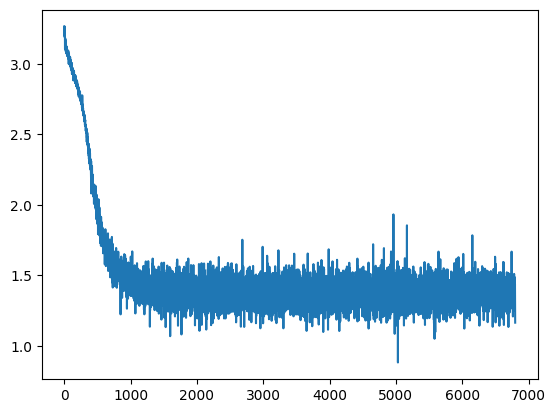

In [ ]:
plt.plot(losses)

In [ ]:
y_pred = model2(X_test.type(torch.float32))

In [ ]:
multiclass_f1_score(y_pred, y_test, num_classes=15)

tensor(0.5700, device='cuda:0')